### Simple Segmentation

C:\Users\abinenfe\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1820: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


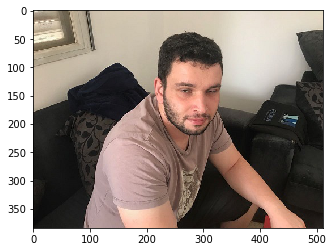

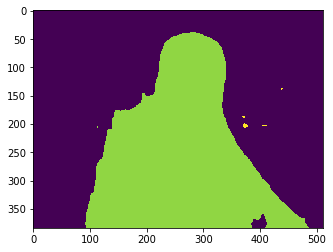

In [2]:
%matplotlib inline

import sys, os
sys.path.append('C:/Users/abinenfe/Documents/Studies/Computer Vision HW - Git/vision/hw2/q3/')
sys.path.append('C:/Users/abinenfe/Documents/Studies/Computer Vision HW - Git/vision/hw2/q3/pytorch_segmentation_detection/')
sys.path.insert(0, 'C:/Users/abinenfe/Documents/Studies/Computer Vision HW - Git/vision/hw2/q3/vision/')

# Use second GPU -pytorch-segmentation-detection- change if you want to use a first one
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Ariel - No CUDA devices for us :(

from PIL import Image
from matplotlib import pyplot as plt

import torch
from torchvision import transforms
from torch.autograd import Variable
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated

import numpy as np


img_path = 'demo_img_igor.jpeg'

valid_transform = transforms.Compose(
                [
                     transforms.ToTensor(),
                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                ])

img_not_preprocessed = Image.open(img_path).convert('RGB')

img = valid_transform(img_not_preprocessed)

img = img.unsqueeze(0)

# img = Variable(img.cuda())
img = Variable(img)

fcn = resnet_dilated.Resnet34_8s(num_classes=21)
fcn.load_state_dict(torch.load('resnet_34_8s_68.pth', map_location=lambda storage, loc: storage))
#fcn.cuda()
fcn.eval()

res = fcn(img)

_, tmp = res.squeeze(0).max(0)

segmentation = tmp.data.cpu().numpy().squeeze()

plt.imshow(img_not_preprocessed)
plt.show()

plt.imshow(segmentation)
plt.show()

### Create a sticker with a contour

In [ ]:
import skimage.morphology

image_np = np.asarray(img_not_preprocessed)

prediction_mask = (segmentation == 15)

# Let's apply some morphological operations to
# create the contour for our sticker

cropped_object = image_np * np.dstack((prediction_mask,) * 3)

square = skimage.morphology.square(5)

temp = skimage.morphology.binary_erosion(prediction_mask, square)

negative_mask = (temp != True)

eroding_countour = negative_mask * prediction_mask

eroding_countour_img = np.dstack((eroding_countour, ) * 3)

cropped_object_no_contour = cropped_object.copy()

cropped_object[eroding_countour_img] = 248

png_transparancy_mask = np.uint8(prediction_mask * 255)

image_shape = cropped_object.shape

png_array = np.zeros(shape=[image_shape[0], image_shape[1], 4], dtype=np.uint8)
png_array[:, :, :3] = cropped_object
png_array[:, :, 3] = png_transparancy_mask

png_array_1 = np.zeros(shape=[image_shape[0], image_shape[1], 4], dtype=np.uint8)
png_array_1[:, :, :3] = cropped_object_no_contour
png_array_1[:, :, 3] = png_transparancy_mask

plt.imshow(cropped_object)

plt.imsave('sticker_contour.png', png_array)
plt.imsave('sticker_no_contour.png', png_array_1)

### Create new background

In [ ]:
layer1 = Image.open("demo_img_epic_background.jpg")
layer2_tmp = Image.open("sticker_no_contour.png")
layer2 = layer2_tmp.resize((320, 180))

final1 = Image.new("RGBA", layer1.size)
final1.paste(layer1)
final1.paste(layer2, (100,600), layer2)

final1


### Iphone's portrait mode

### Original picture

In [ ]:
img_not_preprocessed

### Portrait mode

In [ ]:
from PIL import ImageFilter

blurred_image = img_not_preprocessed.filter(ImageFilter.GaussianBlur(radius=4))

final1 = Image.new("RGBA", blurred_image.size)
final1.paste(blurred_image)
final1.paste(layer2_tmp, (0,0), layer2_tmp)

final1